In [1]:
%matplotlib inline

In [35]:
"""
UTF-8, Python 3

------------------
Flaring SPI
------------------

Ekaterina Ilin, 2021, MIT License

De-trending Kepler and TESS

- get table of Kepler exoplanet system light curves
- fetch FLC
- get system info from table
- mask transits
- apply custom detrending
- search flares
- save results
"""


import copy
import time

from funcs.notebook import *
from funcs.detrend import estimate_detrended_noise, custom_detrending
from funcs.transitmask import get_full_transit_mask

from altaipony.lcio import from_mast
from altaipony.flarelc import FlareLightCurve


sep = "-----------------------------------------"

def mprint(message):
    print(sep)
    print(message)
    print(sep)
    
offset = {"K2":2454833.,"Kepler":2454833.,"TESS":2457000.}    



# Composite Table of confirmed exoplanets
path = "20_01_2021_confirmed_uncontroversial_exoplanet_systems.csv"

mprint(f"[UP] Using confirmed and uncontroversial "
      "entries in NASA Composite Table from {path}")

exokepler = pd.read_csv(f"../data/{path}") # composite table

# read in TESS-TOI sample 
path = "../data/2021_01_13_TESS_TOI_CATALOG.csv"

mprint(f"[UP] Using TESS-TOI Table from {path}")

exotess = pd.read_csv(path, skiprows=4)

# rename the relevant columns for transit masking
exotess = exotess.rename(index=str, 
                         columns={'Transit Duration Value':"pl_trandur",
                                  'Orbital Period Value': "pl_orbper", 
                                  'Epoch Value':"pl_tranmidepoch"})


# read in list of LCs to search
es = pd.read_csv("../data/20_01_2021_full_kepler_k2_tess_exoplanet_lcs_some_excluded.csv")

# select only Kepler and TESS, ignore K2 for now
eskeptess = es[(es.mission=="TESS") | (es.mission=="Kepler")]


#work through a subset first
# eskeptess = eskeptess.iloc[[471]]
eskeptess = eskeptess[(eskeptess.ID == "AU Mic") & (eskeptess.qcs == 27)]

#track progress
N, n = eskeptess.shape[0], 0

-----------------------------------------
[UP] Using confirmed and uncontroversial entries in NASA Composite Table from {path}
-----------------------------------------
-----------------------------------------
[UP] Using TESS-TOI Table from ../data/2021_01_13_TESS_TOI_CATALOG.csv
-----------------------------------------


In [14]:
N

1

Found cached file /media/ekaterina/40A2-49D9/lcs/mastDownload/TESS/tess2020186164531-s0027-0000000441420236-0189-a_fast/tess2020186164531-s0027-0000000441420236-0189-a_fast-lc.fits with expected size 10558080.
4% (4549/105285) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
4% (4549/105285) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
Found cached file /media/ekaterina/40A2-49D9/lcs/mastDownload/TESS/tess2020186164531-s0027-0000000441420236-0189-s/tess2020186164531-s0027-0000000441420236-0189-s_lc.fits with expected size 1785600.
4% (765/17546) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
4% (765/17546) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-1.0.0-py3.6.egg/altaipony/lcio.py:114: ResourceWarning: unclosed file <_io.FileIO name='/media/ekaterina/40A2-49D9/lcs/mast

-----------------------------------------
2 light curves available for AU Mic in TESS.
-----------------------------------------
[2036.28345208 2036.28368356 2036.28391505 ... 2060.64794059 2060.64817208
 2060.64840356] (100736,)


Found 8 candidate(s) in the (0,21268) gap.
Found 9 candidate(s) in the (21268,50506) gap.
Found 16 candidate(s) in the (50506,100093) gap.


100.0%, [1/1]


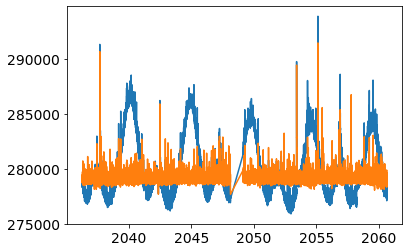

In [37]:
for i, row in eskeptess.iterrows():

    # Get system info: all planet, any transits
    if row.mission == "TESS":
        # TIC is unique ID for star
        system = exotess[(exotess.TIC == row.TIC)]

    elif row.mission == "Kepler":
        # ID is unique, also ignore entries that have no transits
        # because there is nothing to mask (they are still searched for flares)
        system = exokepler[(exokepler.hostname == row.ID) &
                           (exokepler.discoverymethod == "Transit")]
        if system.shape[0] > 0:
            system["pl_tranmidepoch"] = system.pl_tranmid - offset[system.iloc[0].disc_facility]

    # fetch light curve from MAST
    flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short", 
                    download_dir="/media/ekaterina/40A2-49D9/lcs")

    # make it a list of LCs even if only one LC is returned
    if type(flc) == FlareLightCurve:

        flc = [flc]

    elif type(flc) == list:

        flc = flc

    # info
    mprint(f"{len(flc)} light curves available for {row.ID} in {row.mission}.")

    # loop over all LCs for the system    
    for f in flc[:1]:

        # If any planet transiting
        if system.shape[0] > 0:

            # mask transits
            tranmask = get_full_transit_mask(system, f, pad=0)
            f.flux[tranmask] = np.nan
    
        print(f.time, f.time.shape)
        plt.plot(f.time, f.flux)
        # apply custom detrending
        fd = custom_detrending(f, pad=3)
        plt.plot(fd.time, fd.flux)

        # define two hour window for rolling std
#         print(fd.time, np.diff(fd.time))
        w = np.floor(1./12./np.nanmin(np.diff(fd.time)))
        if w%2==0: 
            w+=1

        # use window to estimate the noise in the LC
        df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=1.5)

        # search the residual for flares
        ff = df.find_flares(addtail=True, tailthreshdiff=1.5).flares

        # get timestamp for result
        tstamp = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())

        # add meta info to flare table
        # if no flares found, add empty row
        if ff.shape[0]==0:
            ff["total_n_valid_data_points"] = df.detrended_flux.shape[0]
            ff["ID"] = row.ID
            ff["qcs"] = row.qcs
            ff["mission"] = row.mission
            ff["tstamp"] = tstamp
            ff = ff.append({"total_n_valid_data_points":df.detrended_flux.shape[0],
                            "ID":row.ID,
                            "qcs" : row.qcs,
                            "mission":row.mission,
                            "tstamp":tstamp},
                             ignore_index=True)

        # otherwise add ID, QCS and mission
        else:
            ff["ID"] = row.ID
            ff["qcs"] = row.qcs
            ff["mission"] = row.mission
            ff["tstamp"] = tstamp

        # add results to file
        with open("../results/AUmic_flares_ttd15.csv", "a") as file:
            ff.to_csv(file, index=False, header=True)

    # info
    n += 1
    print(f"{n / N * 100.:.1f}%, [{n}/{N}]")

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(f.time, f.flux,zorder=-20, c="orange")
plt.xlim(122,124)

In [ ]:
# plt.figure(figsize=(16,5))
# plt.plot(df.time, df.flux,zorder=-20, c="orange")
# plt.plot(df.time, df.detrended_flux,zorder=-10, c="yellow")
# plt.plot(tu, fl,zorder=-30)
# # plt.plot(df.time, df.flux-df.detrended_flux,zorder=-20, c="orange")

# m = np.nanmedian(df.detrended_flux )
# plt.fill_between(df.time, m + 3*df.detrended_flux_err,
#                  m - 3*df.detrended_flux_err, alpha=.7)
# plt.xlim(df.time[0], df.time[-1])
# # plt.ylim(161400,162500)
# # plt.xlim(2102,2105)

In [ ]:
ff = df.find_flares().flares

In [ ]:
# m = np.nanmedian(df.detrended_flux )
# for idx, flare in ff.iterrows():
#     df_ = df[flare.istart-280:flare.istop+280]
#     plt.figure(figsize=(16,5))
#     plt.scatter(df_.time, df_.flux,zorder=-20, c="orange")
#     plt.plot(df_.time, df_.detrended_flux,zorder=-10, c="yellow")

#     plt.fill_between(df_.time, m + 3*df_.detrended_flux_err,
#                      m - 3*df_.detrended_flux_err, alpha=.7)
#     plt.xlim(df_.time[0],df_.time[-1])


In [ ]:
if ff.shape[0]==0:
    ff["total_n_valid_data_points"] = df.detrended_flux.shape[0]
    ff["ID"] = row.ID
    ff["qcs"] = row.qcs
    ff["mission"] = row.mission
    ff = ff.append({"total_n_valid_data_points":df.detrended_flux.shape[0],
                    "ID":row.ID,
               "qcs" : row.qcs,
               "mission":row.mission},
              ignore_index=True)
else:
    ff["ID"] = row.ID
    ff["qcs"] = row.qcs
    ff["mission"] = row.mission

In [ ]:
with open("../results/flares.csv", "a") as file:
    ff.to_csv(file, index=False, header=False)

In [ ]:
TSTART = time.time()

In [ ]:
exokepler.disc_facility.unique()

In [ ]:
t0, tf = f.time[0], f.time[-1]

for i, row in system.iterrows():
    if (np.isnan(row.pl_orbper)) & (~np.isnan(row.pl_tranmidepoch)):
        system.loc[i,"pl_orbper"] = (tf - t0) * 1e6 

In [ ]:
system[["pl_orbper","pl_tranmidepoch"]]

In [ ]:
from funcs.transitmask import get_transit_mid_epochs


assert (get_transit_mid_epochs(30., 300., 20., 40.) ==
        np.array([-270.,   30.,  330.])).all()

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(f.time, f.flux)
plt.xlim(2139,2139.5)

In [ ]:
flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short")

In [ ]:
flc = flc[0]

In [ ]:
flc.flux.shape

In [ ]:
if system.shape[0] > 0:

    # mask transits
    tranmask = get_full_transit_mask(system, flc, pad=0)
    flc.flux[tranmask] = np.nan

# apply custom detrending
fd = custom_detrending(flc)

# define two hour window for rolling std
#         print(fd.time, np.diff(fd.time))
w = np.floor(1./12./np.nanmin(np.diff(fd.time)))
if w%2==0: 
    w+=1

# use window to estimate the noise in the LC
df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=3.)


In [ ]:
aumic = pd.read_csv("../results/AUMic_flares_pad3.csv")
aumic = aumic.sort_values("ampl_rec",ascending=False)

%matplotlib inline
for l, row in aumic.iloc[:10].iterrows():
    plt.figure(figsize=(17,5))
    ts, tf = row.tstart, row.tstop
    _ = df[np.where((df.time>=ts-.2) & (df.time<=tf+.2))]
    plt.plot(_.time, _.detrended_flux)
    plt.fill_between(_.time, _.it_med+_.detrended_flux_err, 
                     _.it_med-_.detrended_flux_err,alpha=0.7,facecolor="orange")
#     plt.plot(flc.time, flc.flux)
#     plt.xlim(df.time[0],df.time[-1]);
    
    plt.xlim(ts - .1, tf + .1)
    _ = df[np.where((df.time>=ts) & (df.time<=tf))]
    plt.plot(_.time, _.detrended_flux, c="r")
#     plt.ylim(277500,280000)

In [33]:
aumic.head()

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,ID,qcs,mission,tstamp
22,72619,72623,3571855,3571859,2054.278483,2054.279409,0.179687,0.028879,0.002303,0.000926,100093,AU Mic,27,TESS,26_01_2021_13_04_43
30,91719,91730,3590998,3591009,2058.709744,2058.712291,0.417710,0.035392,0.002492,0.002546,100093,AU Mic,27,TESS,26_01_2021_13_04_43
11,45031,45036,3539839,3539844,2046.867286,2046.868444,0.217001,0.022594,0.002685,0.001157,100093,AU Mic,27,TESS,26_01_2021_13_04_43
18,57512,57518,3556748,3556754,2050.781468,2050.782857,0.219700,0.025168,0.003001,0.001389,100093,AU Mic,27,TESS,26_01_2021_13_04_43
8,21326,21337,3516090,3516101,2041.369706,2041.372253,0.504275,0.038434,0.003047,0.002546,100093,AU Mic,27,TESS,26_01_2021_13_04_43


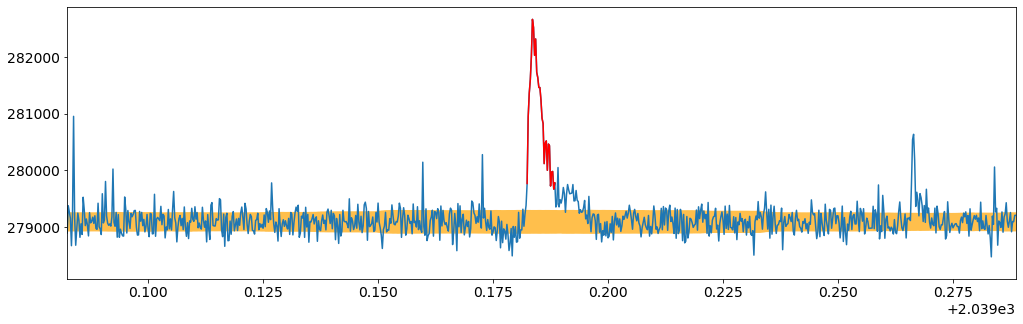

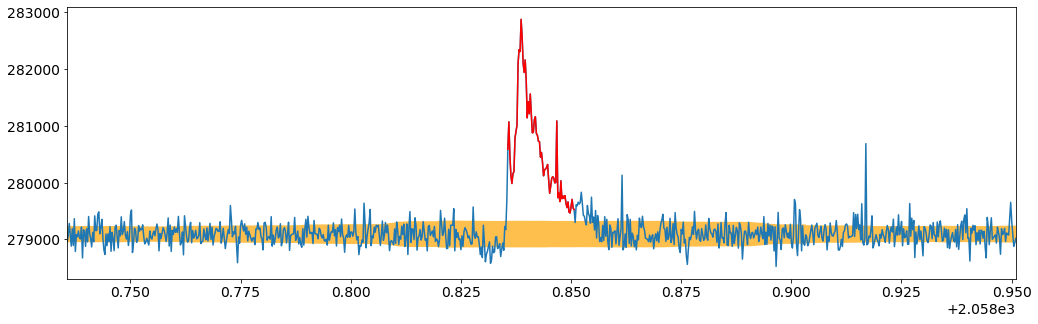

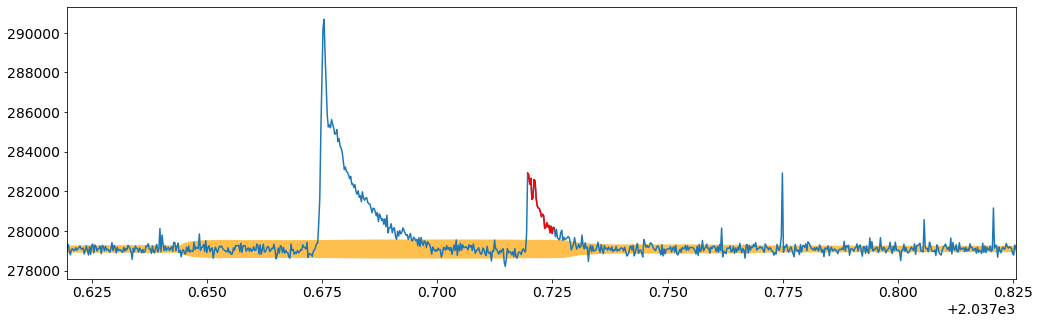

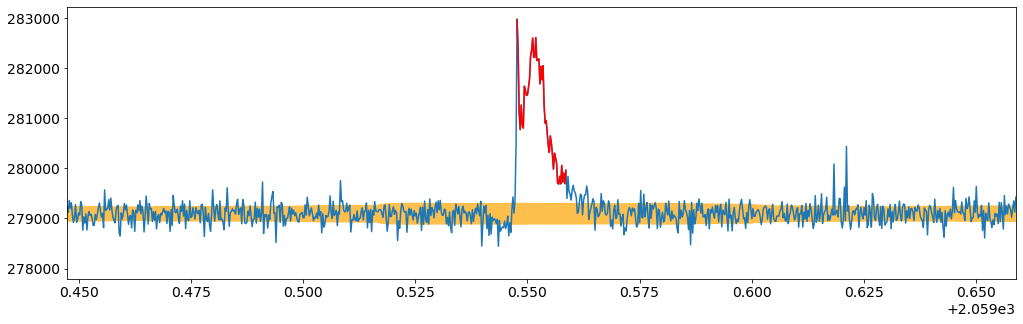

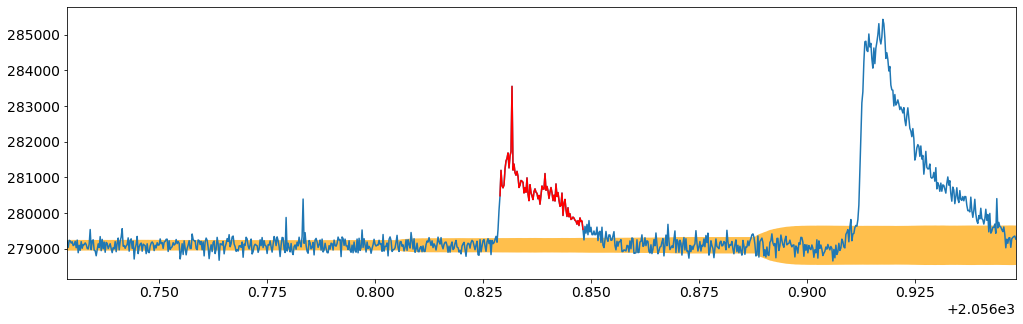

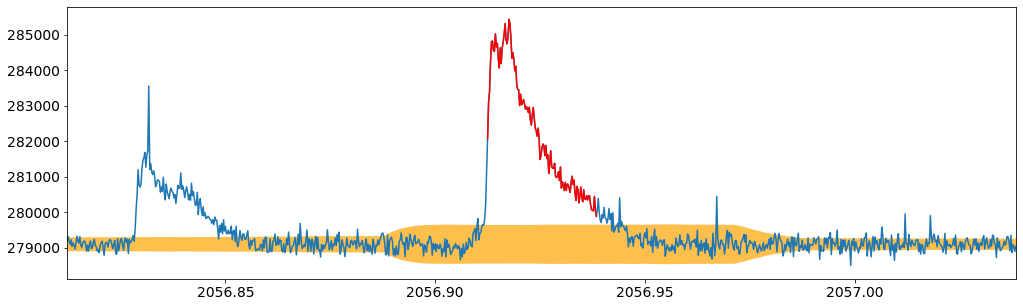

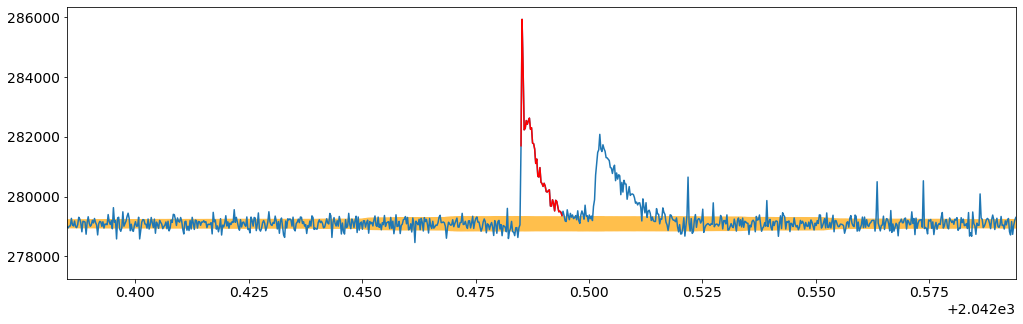

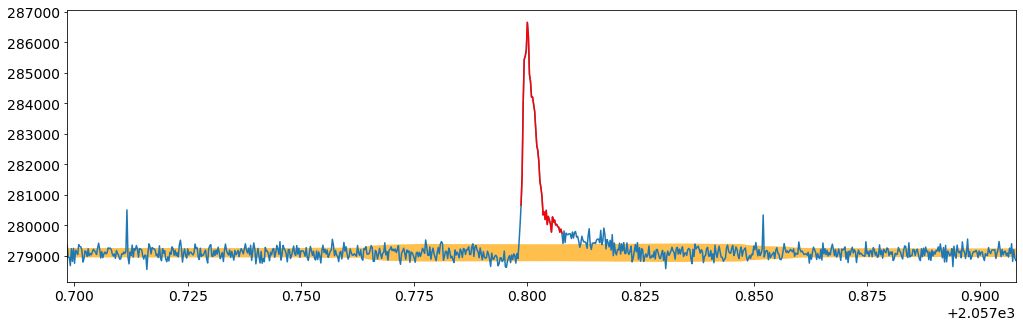

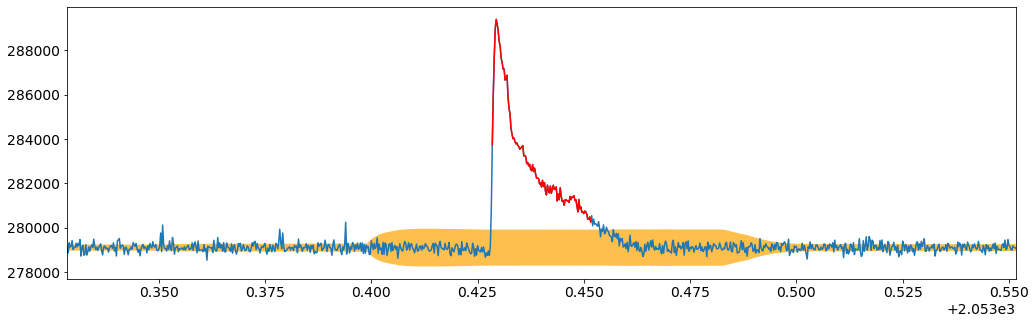

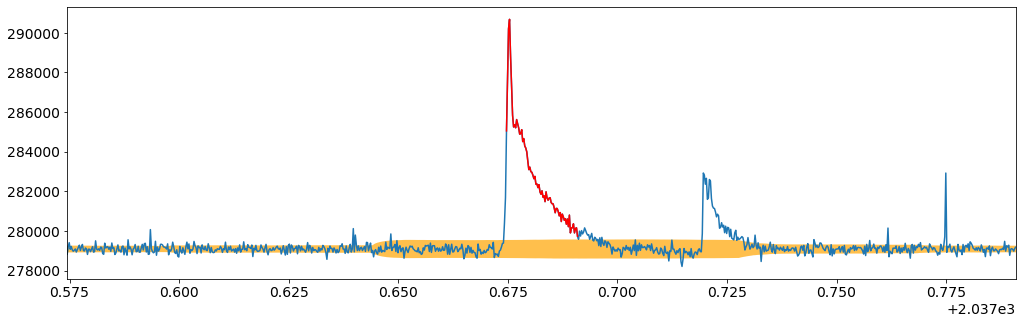

In [39]:
aumic = pd.read_csv("../results/AUMic_flares_pad3_sig1_addtail.csv")
aumic = aumic.sort_values("ampl_rec",ascending=True)

%matplotlib inline
for l, row in aumic.iloc[-10:].iterrows():
    plt.figure(figsize=(17,5))
    ts, tf = row.tstart, row.tstop
    _ = df[np.where((df.time>=ts-.2) & (df.time<=tf+.2))]
    plt.plot(_.time, _.detrended_flux)
    plt.fill_between(_.time, _.it_med+_.detrended_flux_err, 
                     _.it_med-_.detrended_flux_err,alpha=0.7,facecolor="orange")
#     plt.plot(flc.time, flc.flux)
#     plt.xlim(df.time[0],df.time[-1]);
    
    plt.xlim(ts - .1, tf + .1)
    _ = df[np.where((df.time>=ts) & (df.time<=tf))]
    plt.plot(_.time, _.detrended_flux, c="r")
#     plt.ylim(277500,280000)

In [ ]:
# read in list of LCs to search
es = pd.read_csv("../data/20_01_2021_full_kepler_k2_tess_exoplanet_lcs_some_excluded.csv")

# select only Kepler and TESS, ignore K2 for now
eskeptess = es[(es.mission=="TESS") | (es.mission=="Kepler")]



In [24]:
32000/60/24

22.222222222222225

In [ ]:
fla[fla.ID=="16 Cyg B"]

In [ ]:
~eskeptess.ID.isin(fla.ID.unique())

In [ ]:
eskeptess.shape

In [ ]:
10 ** np.linspace(-2,4,5)

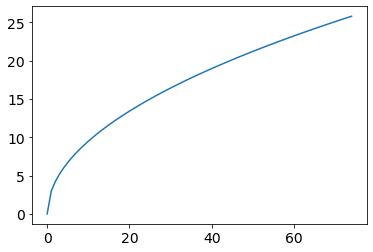

In [40]:
x = np.arange(75)
y = 3*np.sqrt(x)
plt.plot(x,y)